In [1]:
%env DISPLAY=:0.0
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=16
%env MKL_NUM_THREADS=1
%env NUMEXPR_NUM_THREADS=1

env: DISPLAY=:0.0
env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=16
env: MKL_NUM_THREADS=1
env: NUMEXPR_NUM_THREADS=1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import arviz
from cmdstanpy import cmdstan_path, CmdStanModel
import cmdstanpy
%matplotlib inline

import zusammen

/Users/fran/.virtualenvs/grb/lib/python3.8/site-packages/astromodels/functions/function.py:140: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  function_definition = my_yaml.load(dct['__doc__'])
/Users/fran/.virtualenvs/grb/lib/python3.8/site-packages/astromodels/core/parameter.py:555: UserWarning: We have set the min_value of xc to 1e-99 because there was a postive transform
  warnings.warn('We have set the min_value of %s to 1e-99 because there was a postive transform' % self.path)


Configuration read from /Users/fran/.threeML/threeML_config.yml



WARNING TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



## cosmogrb -> Stan

In [3]:
from zusammen.utils.sim2fits import AnalysisBuilder

SynthGRB_0


2020-11-26 16:11:03 Francescas-MacBook-Pro.local astropy[65786] WARNING VerifyWarning: Card is too long, comment will be truncated.
2020-11-26 16:11:03 Francescas-MacBook-Pro.local astropy[65786] WARNING AstropyDeprecationWarning: "clobber" was deprecated in version 2.0 and will be removed in a future version. Use argument "overwrite" instead.

WARNING UserWarning: The TTE file SynthGRB_0/tte_SynthGRB_0_n6.fits contains duplicate time tags and is thus invalid. Contact the FSSC 


WARNING UserWarning: The default choice for MATRIX extension failed:KeyError("Extension ('MATRIX', 1) not found.")available: None 'EBOUNDS' 'SPECRESP MATRIX'




WARNING UserWarning: The TTE file SynthGRB_0/tte_SynthGRB_0_n7.fits contains duplicate time tags and is thus invalid. Contact the FSSC 


WARNING UserWarning: The default choice for MATRIX extension failed:KeyError("Extension ('MATRIX', 1) not found.")available: None 'EBOUNDS' 'SPECRESP MATRIX'


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.536451816558838)




WARNING UserWarning: The TTE file SynthGRB_0/tte_SynthGRB_0_n8.fits contains duplicate time tags and is thus invalid. Contact the FSSC 


WARNING UserWarning: The default choice for MATRIX extension failed:KeyError("Extension ('MATRIX', 1) not found.")available: None 'EBOUNDS' 'SPECRESP MATRIX'


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.910734176635742)




WARNING UserWarning: The TTE file SynthGRB_0/tte_SynthGRB_0_b1.fits contains duplicate time tags and is thus invalid. Contact the FSSC 


WARNING UserWarning: The default choice for MATRIX extension failed:KeyError("Extension ('MATRIX', 1) not found.")available: None 'EBOUNDS' 'SPECRESP MATRIX'




WARNING UserWarning: The default choice for MATRIX extension failed:KeyError("Extension ('MATRIX', 1) not found.")available: None 'EBOUNDS' 'SPECRESP MATRIX' 'SPECRESP MATRIX' 'SPECRESP MATRIX' 'SPECRESP MATRIX' 'SPECRESP MATRIX' 'SPECRESP MATRIX'


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.536451816558838)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.910734176635742)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.536451816558838)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.910734176635742)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.536451816558838)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.910734176635742)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.536451816558

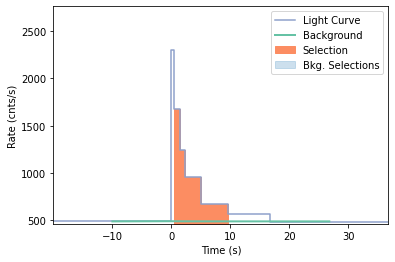

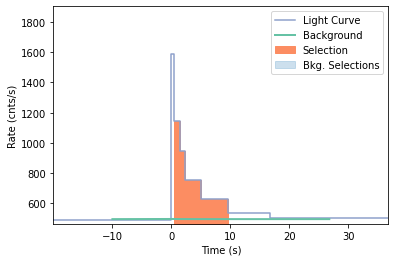

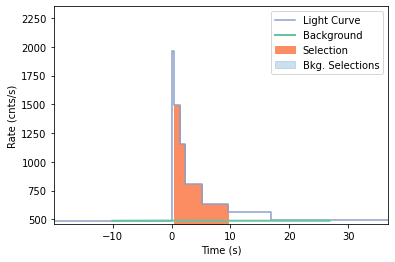

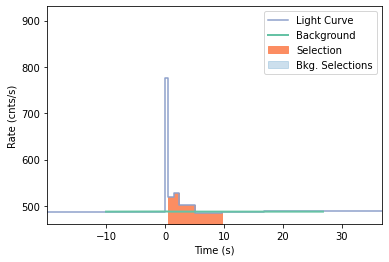

In [4]:
analysis_builder = AnalysisBuilder("data/survey.h5", use_bb=True)
output = zusammen.DataSet.from_dict(analysis_builder.yaml_params)
output.to_hdf5_file("data/survey_proc.h5")

## Fit

In [250]:
ds = zusammen.DataSet.from_hdf5_file('data/survey_proc.h5')

In [251]:
#N_gen_spectra = 100
#model_energy = np.logspace(0,5,N_gen_spectra)
#data['N_gen_spectra'] = N_gen_spectra
#data['model_energy'] = model_energy

warmup = 500
samps = 250
total = warmup + samps
chains = 4

In [252]:
model = CmdStanModel(stan_file="stan/simple_cor.stan", 
                     cpp_options={'STAN_THREADS': 'TRUE'})

2020-11-27 18:49:19 Francescas-MacBook-Pro.local cmdstanpy[65786] INFO compiling stan program, exe file: /Users/fran/projects/zusammen/examples/stan/simple_cor
2020-11-27 18:49:19 Francescas-MacBook-Pro.local cmdstanpy[65786] INFO compiler options: stanc_options={'include_paths': ['/Users/fran/projects/zusammen/examples/stan']}, cpp_options={'STAN_THREADS': 'TRUE'}
2020-11-27 18:49:40 Francescas-MacBook-Pro.local cmdstanpy[65786] INFO compiled model file: /Users/fran/projects/zusammen/examples/stan/simple_cor


In [253]:
os.environ["STAN_NUM_THREADS"] = "8"

data = ds.to_stan_dict()
# TODO: Fix in ogip2stan
data["response"] = data["response"].transpose(0, 1, 3, 2)
cmdstanpy.utils.jsondump("test_data.json", data)

fit = model.sample(
    data=data,
    cores=8,
    iter_warmup=warmup,
    iter_sampling=samps,
    chains=chains,
    max_treedepth=10,
    show_progress="notebook")

av = arviz.from_cmdstanpy(fit)

In [257]:
#fit.summary

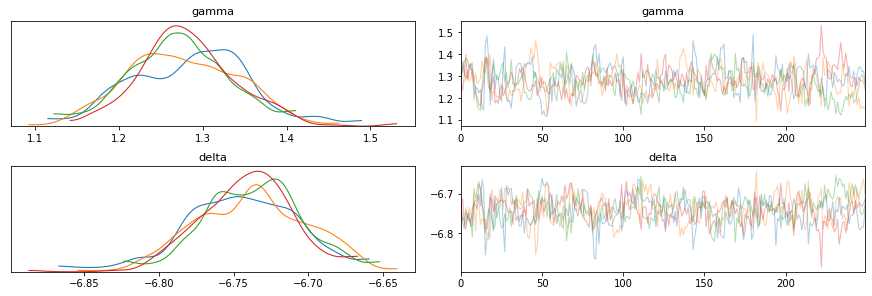

In [258]:
arviz.plot_trace(av, var_names=["gamma", "delta"]);

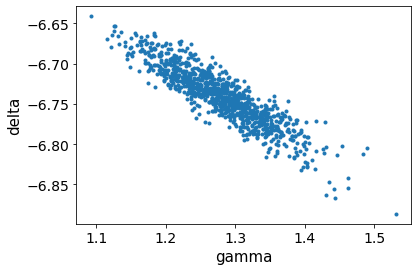

In [259]:
arviz.plot_pair(av, var_names=["gamma", "delta"], divergences=True);

### Compare with truth

In [260]:
from cosmogrb.universe.survey import Survey
from popsynth.distributions.cosmological_distribution import luminosity_distance

In [261]:
survey = Survey.from_file('data/survey.h5')
grb_reload = survey['SynthGRB_0'].grb

gamma_true = grb_reload._source_params["gamma"]
Nrest = grb_reload._source_params["Nrest"] 
z = grb_reload.z
dl = luminosity_distance(grb_reload.z)
delta_true = np.log10(Nrest / (4 * np.pi * dl**2))
alpha_true = grb_reload._source_params["alpha"]
ep_start = grb_reload._source_params["ep_start"]

In [262]:
N_intervals = np.shape(av.posterior.alpha)[-1]

Text(0, 0.5, 'log_energy_flux')

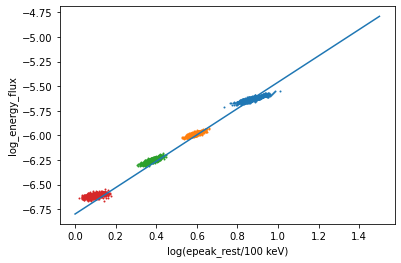

In [269]:
fig, ax = plt.subplots()

for i in range(N_intervals):

    log_epeak_rest = np.log10(10**np.concatenate(av.posterior.log_epeak[:,:,i]) 
                              * (1+z) / 100)
    ax.scatter(log_epeak_rest,
               np.concatenate(av.posterior.log_energy_flux[:,:,i]), s=1)
    
xx = np.linspace(0,1.5,50)

ax.plot(xx, gamma_true*xx + delta_true)
ax.set_xlabel("log(epeak_rest/100 keV)")
ax.set_ylabel("log_energy_flux")

Text(0.5, 0, 'log_epeak')

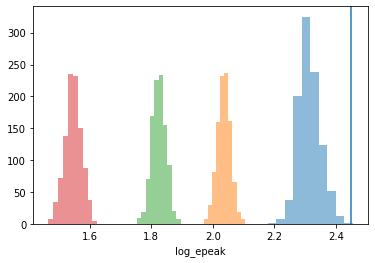

In [270]:
fig, ax = plt.subplots()
for i in range(N_intervals):
    ax.hist(np.concatenate(av.posterior.log_epeak[:,:,i]), alpha=0.5)
ax.axvline(np.log10(ep_start))
ax.set_xlabel("log_epeak")

Text(0, 0.5, 'alpha')

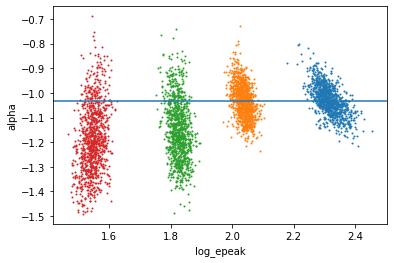

In [271]:
fig, ax = plt.subplots()

for i in range(N_intervals):

    ax.scatter(np.concatenate(av.posterior.log_epeak[:,:,i]),
               np.concatenate(av.posterior.alpha[:,:,i]), s=1)
ax.axhline(alpha_true)
#ax.axvline(np.log10(ep_start))
ax.set_xlabel("log_epeak")
ax.set_ylabel("alpha")

[Text(0, 0.5, 'alpha'), Text(0.5, 0, 'log energy flux')]

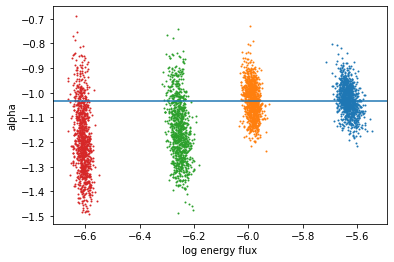

In [272]:
fig, ax = plt.subplots()

for i in range(N_intervals):

    ax.scatter(np.concatenate(av.posterior.log_energy_flux[:,:,i]),
               np.concatenate(av.posterior.alpha[:,:,i]), s=1)
ax.axhline(alpha_true)
ax.set(xlabel="log energy flux", ylabel="alpha")

In [273]:
av.posterior.to_netcdf("output/simple_cor_test.nc")